# Analysis of reflectometry data
Searching for MHD waves

In [1]:
#import math
from scipy import io
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import scipy.integrate
import pandas as pd
from IPython.display import display
import time
import matplotlib.colors as colors
import random
import glob
import os

First, we load our signal.

In [2]:
#%%script false
#path ='C:\\Users\\Marci\\Documents\\transientwaves\\imputdata\\in\\'#pc
path ='C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\in\\'#laptop

for filename in glob.glob(os.path.join(path, '*.sav')):
    sav1 = io.readsav(filename, python_dict = True)
    print('Loaded: '+filename)
    print('\n')

Loaded: C:\Users\win10\Downloads\transient-waves\inputdata\in\AUGD_30667_FRS.sav




In [3]:
#%%script false
shot_i=33
#print(sav1)
s=np.array(sav1['data'][shot_i])#
x=np.array(sav1['timeax'])
print("\n", sav1['channels'])
print("\n", s)
#print("\n", sav1['channels'][shot_i])
sxr_name=str(sav1['channels'][shot_i])[2:4]+'R'+str(sav1['channels'][shot_i])[5:-1]
shot=os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+', '+str(sav1['channels'][shot_i])[2:-1]#sxr_name#
print("\n",shot)


 [b'FRS-ne:1:1:1' b'FRS-ne:2:1:1' b'FRS-ne:3:1:1' b'FRS-ne:4:1:1'
 b'FRS-ne:5:1:1' b'FRS-ne:6:1:1' b'FRS-ne:7:1:1' b'FRS-ne:8:1:1'
 b'FRS-ne:9:1:1' b'FRS-ne:10:1:1' b'FRS-ne:11:1:1' b'FRS-ne:12:1:1'
 b'FRS-ne:13:1:1' b'FRS-ne:14:1:1' b'FRS-ne:15:1:1' b'FRS-ne:16:1:1'
 b'FRS-ne:17:1:1' b'FRS-ne:18:1:1' b'FRS-ne:19:1:1' b'FRS-ne:20:1:1'
 b'FRS-ne:21:1:1' b'FRS-ne:22:1:1' b'FRS-ne:23:1:1' b'FRS-ne:24:1:1'
 b'FRS-ne:25:1:1' b'FRS-ne:26:1:1' b'FRS-ne:27:1:1' b'FRS-ne:28:1:1'
 b'FRS-ne:29:1:1' b'FRS-ne:30:1:1' b'FRS-ne:31:1:1' b'FRS-ne:32:1:1'
 b'FRS-ne:33:1:1' b'FRS-ne:34:1:1' b'FRS-ne:35:1:1' b'FRS-ne:36:1:1'
 b'FRS-ne:37:1:1' b'FRS-ne:38:1:1' b'FRS-ne:39:1:1' b'FRS-ne:40:1:1'
 b'FRS-ne:41:1:1' b'FRS-ne:42:1:1' b'FRS-ne:43:1:1' b'FRS-ne:44:1:1'
 b'FRS-ne:45:1:1' b'FRS-ne:46:1:1' b'FRS-ne:47:1:1' b'FRS-ne:48:1:1'
 b'FRS-ne:49:1:1' b'FRS-ne:50:1:1' b'FRS-ne:51:1:1' b'FRS-ne:52:1:1'
 b'FRS-ne:53:1:1' b'FRS-ne:54:1:1' b'FRS-ne:55:1:1' b'FRS-ne:56:1:1'
 b'FRS-ne:57:1:1' b'FRS-ne:58:1:1' b'FRS-

**main variables**
<br> nyquist - The Nyquist frequency of the signal - biggest recommended calculation range
<br> frangemax - x axis length of Fourier-transform, note, that this does not affect Fourier calculation
<br> 
<br> samples - sample points of the first graph
<br> s_rate - sample rate (Hz)

In [15]:
#%%script false
s = s.astype(float)
x = x.astype(float)
samples=s.size
#full_f = np.zeros(samples)
t=max(x)-min(x)
nyquist=samples/2/t
frangemax=nyquist#250000#
xf=np.linspace(0.0, frangemax, int(frangemax*t+1))
s_rate=x.size/t
print(nyquist)
print(x.size)

usewidgets=0
import ipywidgets as widgets
view=widgets.FloatSlider()
if int(usewidgets)==int(1):
    display(view)
else:
    view.value=0

The widget below controls the wisible range of the chart under it. Note that this is only for visualisation, the program calculates with the whole 0 - t range. The zooming is exponential. Value 0 displays the whole range.

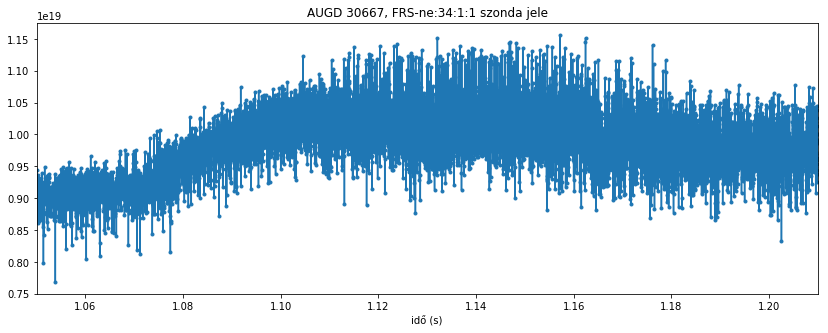


 AUGD 30667, FRS-ne:34:1:1


In [6]:
#%%script false
plt.figure(figsize=(14,5))
plt.title(shot+' szonda jele')
plt.plot(x,s,'.-')
#yaxismax=1/2**(view.value/12)
plt.xlim(min(x),max(x)-(max(x)-min(x))*((view.value/100.4)**0.6))
#plt.ylabel('radiális mágneses tér változás (T/s)')
plt.xlabel('idő (s)')
#plt.savefig(shot+' in.pdf')
plt.show()

print("\n",shot)

The script provided at   *augtwiki/bin/view/Reflectometry/Read*   to load reflectometries

In [45]:
##Read the data
nl = np.array(sav1['data'][shot_i+000]) #rps('neb_LFS')
rl = np.array(sav1['data'][shot_i+100]) #rps('RB_LFS')

plt.figure(figsize=(8,6))
plt.plot(rl,nl,'.-')#.data[1000,:]
#plt.title('%s @ t=%3.2fs'%(nl.description, time[1000]))
#plt.ylabel(nl.unit)
#plt.xlabel('R [%s]' %(rl.units))
plt.show()

Couldn't find program: 'false'


### Trigger and cutting

(300, 8000)
100


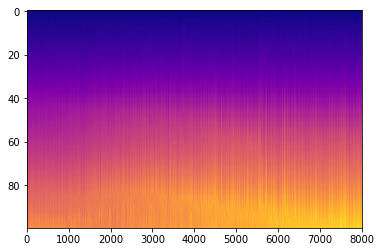

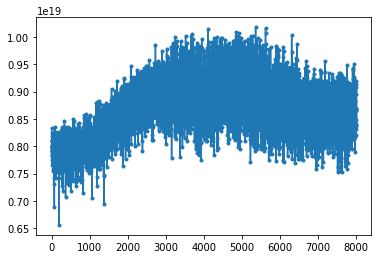

In [40]:
print(sav1['data'].shape)
ne= np.zeros((100,sav1['data'].shape[1]))
freq= np.zeros((100,sav1['data'].shape[1]))
Bmod= np.zeros((100,sav1['data'].shape[1]))
print(ne[:,10].size)

for i in range(100):
    ne[i]= np.array(sav1['data'][i])
    freq[i]= np.array(sav1['data'][shot_i+100])
    Bmod[i]= np.array(sav1['data'][shot_i+200])
    
plt.imshow(ne,aspect='auto',cmap='plasma')
#plt.show()

plt.plot(ne[30,:],'.-')
#plt.show()

## Short-time Fourier transform

We slice the signal up, then from each slice, we substract its average and multiply it with a gaussian window.

8.029205782368284e+30
2.0399738933339025e+38
45


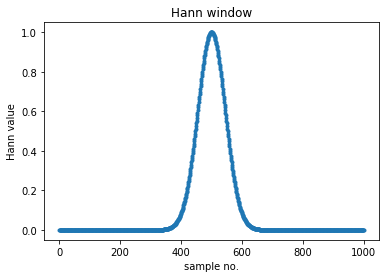

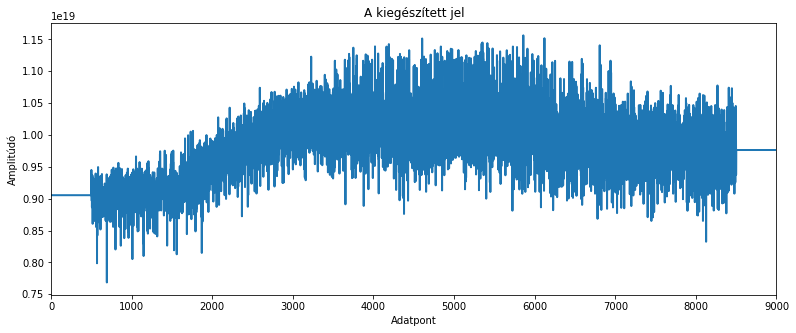

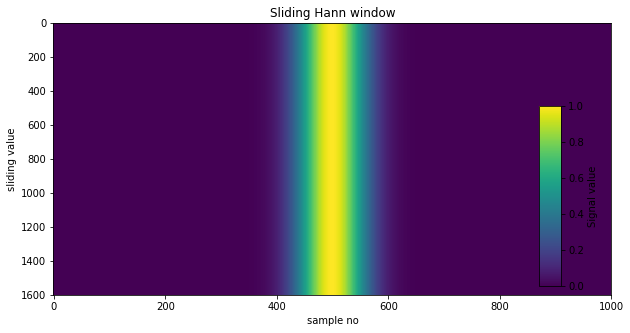

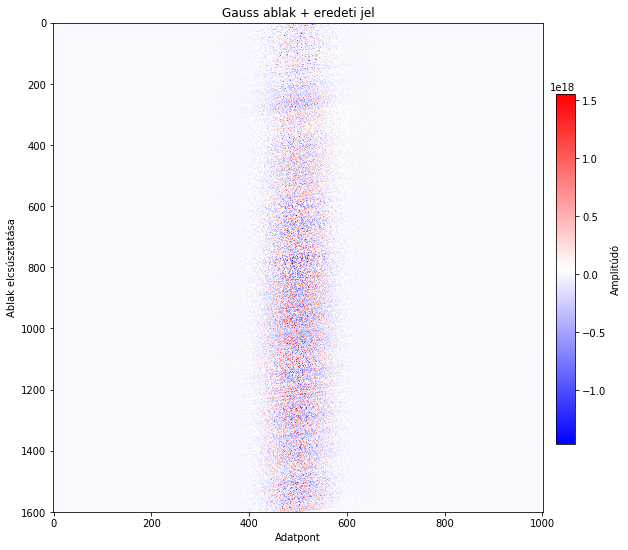

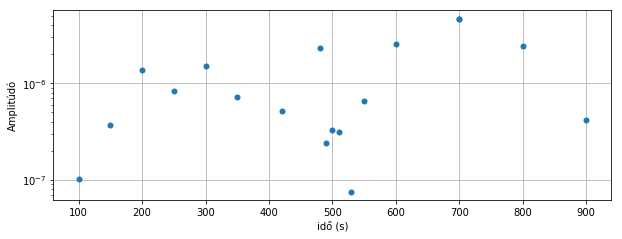

In [48]:
t0=time.time()
win_r = 500 #1000
d_win=5#random.randint(200,300)
std=45 #150
win_base = scipy.signal.gaussian(2*win_r+1, std=std)#np.wining(2*win_r+1)

plt.plot(win_base,".-")
plt.title('Hann window')
plt.xlabel('sample no.')
plt.ylabel('Hann value')
#plt.show()

z_padded_s = np.zeros (samples+2*win_r)
z_0=z_padded_s
z_padded_s[win_r:-win_r] = s
z_padded_s[0:win_r]=np.average(z_padded_s[win_r+1:2*win_r])
z_padded_s[-win_r:]=np.average(z_padded_s[-2*win_r:-win_r-1])
x_win=np.linspace(0.0, t+(2*win_r/s_rate), samples+2*win_r)

plt.figure(figsize=(13,5))
plt.plot(z_padded_s,"-",linewidth = 2)#x_win,idő (s),max(x_win)
plt.xlim((0,samples+2*win_r))
plt.title('A kiegészített jel')
plt.xlabel('Adatpont')
plt.ylabel('Amplitúdó')
plt.savefig('sxr2_p.pdf')
#plt.show()

win = np.zeros((int(samples/d_win+1), 2*win_r+1))
for i in range(int(samples/d_win+1)):
    win [i]=win_base

plt.figure(figsize=(10,5))
plt.imshow(win,aspect='auto')
plt.title('Sliding Hann window')
plt.xlabel('sample no')
plt.ylabel('sliding value')
#plt.subplots_adjust(right=0.95)
cax = plt.axes([0.8, 0.15, 0.03, 0.5])
plt.colorbar(cax=cax).set_label('Signal value')
#plt.show()

z_win = np.zeros((int(samples/d_win+0.9), win_r*2+1))
for i in range(int(samples/d_win+0.9)):
    z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1]-np.average(z_padded_s [d_win*i:d_win*i+win_r+win_r+1]))
    #z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1])

plt.figure(figsize=(9,9))
plt.imshow(z_win,aspect='auto',cmap='bwr')#, extent=(min(x)*s_rate/d_win,max(x)*s_rate/d_win,max(x)*s_rate,min(x)*s_rate)
plt.title('Gauss ablak + eredeti jel')
plt.xlabel('Adatpont')
plt.ylabel('Ablak elcsúsztatása')
plt.subplots_adjust(right=0.88)
cax = plt.axes([0.90, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig('z_win.pdf')
#plt.show()

z_win_fft = np.zeros((int(samples/d_win+0.9), win_r*2+1))
for i in range(int(samples/d_win+0.9)):
    z_win_fft[i] = np.abs(scipy.fftpack.fft(z_win[i]))  
t1=time.time()

print(z_win_fft.min()**2)
print(z_win_fft.max()**2)
print(std)

We can plot one of the slices we calculated earlier.

In [12]:
%%script false
print(win_base[0])
print(z_win[45])
plt.figure(figsize=(4,4))
plt.plot(z_win[1258], linewidth = 0.5)#l
plt.title('Gauss ablak+ eredeti je')
plt.xlabel('Adatpont')
plt.ylabel('Amplitúdó')
#plt.savefig('sxr2_1000.pdf')
plt.show()

Couldn't find program: 'false'


In [13]:
%%script false
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
Axes3D.plot_surface(z_win[:,0],z_win[:,1],z_win[:,2])
plt.show()

Couldn't find program: 'false'


In [14]:
%%script false
t2=time.time()
f_ax_stft, t_ax_stft, z_spy_stft = scipy.signal.stft(s,s_rate,window=win_base, nperseg=hann_r*2+1, noverlap =hann_r*2+1-d_win)
t3=time.time()
print(t1-t0)
print(t3-t2)

Couldn't find program: 'false'


In [15]:
%%script false
z_spy_stft=np.abs(z_spy_stft)**2
z_spy_stft_cutted = np.zeros((int(frangemax*(2*hann_r+1)/s_rate),int(samples/d_win)))#int(frangemax*t+0.01)
for i in range(int(samples/d_win)):
    for j in range(int(frangemax*(2*hann_r+1)/s_rate)):
        z_spy_stft_cutted [j][i] = z_spy_stft [j][i]

Couldn't find program: 'false'


In [49]:
z_win_fft_cutted = np.zeros((int(frangemax*(2*hann_r+1)/s_rate), int(samples/d_win)))
for i in range(int(samples/d_win)):
    for j in range(int(frangemax*(2*hann_r+1)/s_rate)): #int(frangemax*max(x_hann))
        z_win_fft_cutted [j][i] = z_win_fft [i][j]**2

#print(z_spy_stft.shape)
#print(z_spy_stft_cutted.shape)
print(z_win_fft.shape)
print(z_win_fft_cutted.shape)
#print(z_win_fft.max()/abs(z_spy_stft.max()))

(1600, 1001)
(500, 1600)


We can write the calculated STFT to a text file.

In [50]:
%%script false
file2 = open("stft.txt","a")
for i in range(int(samples/d_win/37.5)):#
    for j in range(int(50000*(2*hann_r+1)/s_rate)):
        j2=int(55000*(2*hann_r+1)/s_rate)
        i2=int(samples/d_win/3+samples/d_win/30)
        file2.write(str(i/10)+"\t"+str(j/10)+"\t"+str(np.log10(z_spy_stft [j+j2][i*10+i2])+3)+"\n")#
print(i,j)
file2.close()

Couldn't find program: 'false'


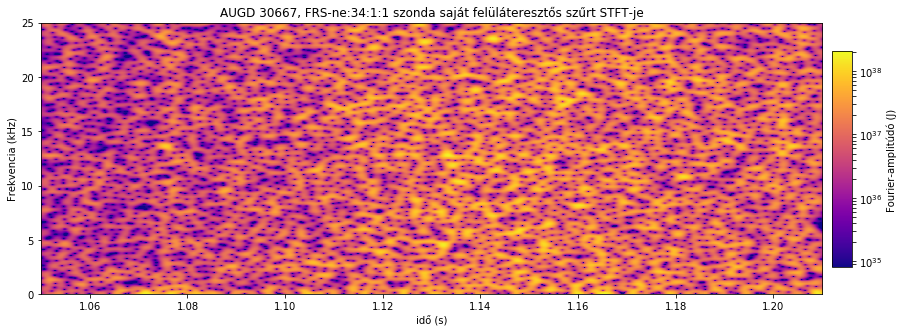

In [60]:
##### %%script false
colornorm=colors.LogNorm(vmin=z_win_fft_cutted.min()*10000, vmax=z_win_fft_cutted.max()/1)
logax = np.linspace(int(np.log10(z_win_fft_cutted.min())),int(np.log10(z_win_fft_cutted.max())),int(np.log10(z_win_fft_cutted.max()))-int(np.log10(z_win_fft_cutted.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(14,5))
#extent=[0,t-(2*hann_r/s_rate),0,frangemax/t],
#plt.figure(figsize=(15,10))
#ax.plot(x,np.abs(full_f),color='g',linewidth=3,linestyle='dashed',alpha=0.6)#img = ax.
img = plt.imshow(z_win_fft_cutted,cmap='plasma',  aspect='auto', extent=[min(x),max(x),frangemax/1000,0], norm=colornorm)#interpolation='gaussian',*30000000/4
#plt.title('39424-es kisülés, J051-es szonda STFT-je')
plt.title(shot+' szonda saját felüláteresztős szűrt STFT-je')
#plt.title('AUGD 34924, B31-40-es szonda STFT-je')
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')#('time (s)')
#plt.xlim(0.642,0.658)
#plt.ylim(90,30)
plt.subplots_adjust(right=0.90)
plt.gca().invert_yaxis()
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier-amplitúdó (J)')
#plt.axis([2.13,2.15,min(s),20000])
#cbar.set_ticks(logax)
#plt.savefig(shot+' stft.pdf')#34924_40
plt.show()

In [1002]:
%%script false
logax = np.linspace(int(np.log10(z_spy_stft_cutted.min())),int(np.log10(z_spy_stft_cutted.max())),int(np.log10(z_spy_stft_cutted.max()))-int(np.log10(z_spy_stft_cutted.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(10,5))
#plt.figure(figsize=(15,10))
#plt.pcolormesh(f_ax, t_ax, np.abs(z_spy_stft), vmin=0, vmax=amp) # extent=[min(x),max(x),frangemax,0],
#ax.plot(x,np.abs(full_f),color='w',linewidth=3,linestyle='dashed')
plt.title('teszt jel szűretlen könyvtári STFT-je')
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')
#plt.ylim(140,0)
plt.subplots_adjust(right=0.90)
img2 = ax.imshow(np.abs(z_spy_stft_cutted),cmap='plasma', interpolation='gaussian', aspect='auto',extent=[min(x),max(x),frangemax/1000,0], norm=colors.LogNorm(vmin=z_spy_stft_cutted.min()*1, vmax=z_spy_stft_cutted.max()/2))#)*4000000/800
plt.gca().invert_yaxis() #extent=[min(x),max(x),frangemax,0],
cbar=plt.colorbar(img2,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier value')
#cbar.set_ticks(logax)
plt.savefig('t_stft1.pdf')
plt.show()

print(np.max(z_spy_stft))

Couldn't find program: 'false'


1000.005
2000009.1000000006
-1113591.921667387
47.54914706678143


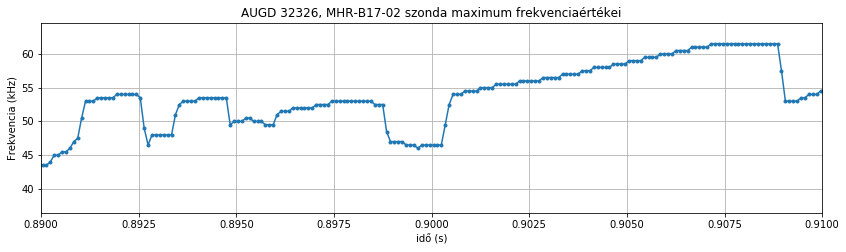

(1001, 2001)
(1000,)


In [1003]:
#%%script false
#ridge_no = 1
print(samples/d_win)

print(s_rate-0.9)
print(nyquist/((2*hann_r+1)/s_rate-0.9))
ridge_d=20000#50#
ridge_d2=8000
ridge_start=40000#2#
ridge = np.zeros(int(samples/d_win+0.9))
ridge_h = np.zeros(int(samples/d_win+0.9))
maxi=z_win_fft.max()/40
print(maxi)

for i in range(int(samples/d_win+0.9)):
    ridgeval=0  #max(z_spy_stft[i][:])
    if (i==0) or (ridge[i-1]==0):
        for j in range(int(ridge_d*(2*hann_r+1)/(s_rate-0.9))):
            j2=j+int((ridge_start)*(2*hann_r+1)/(s_rate-0.9))
            if ridgeval < z_win_fft[i][j2]:
                ridgeval=z_win_fft[i][j2]
                ridge[i]= j2
    else:
        for j in range(int(ridge_d2*(2*hann_r+1)/(s_rate-0.9))):
            j2=int(j+ridge[i-1]-(ridge_d2/2)*(2*hann_r+1)/(s_rate-0.9))
            if ridgeval < z_win_fft[i][j2]:
                ridgeval=z_win_fft[i][j2]
                ridge[i]= j2
                #print(j2, z_spy_stft[j2][i])
    if ridgeval<(maxi):
        ridgeval =0
        ridge [i]=0
    ridge_h[i]=ridgeval**(1/2)
    #print(i, ridge [i])
    #print (i,"  ",ridge[i],"\t", ridgeval,"\t", z_spy_stft[i][int(ridge[i])])

ridge=ridge*(s_rate/(2*hann_r+1))

#proc_x=np.linspace(min(x),max(x),np.size(ridge))
ridge[ ridge==0 ] = np.nan
plt.figure(figsize=(14,3.5))
plt.title(shot+' szonda maximum frekvenciaértékei')
plt.plot(np.linspace(min(x),max(x),np.size(ridge)),ridge/1000,'.-',x,full_f/1000)
plt.grid(True)
#plt.legend(('Kiszámolt', 'Eredeti'))
#yaxismax=1/2**(view.value/12)
plt.xlim(min(x),max(x))
plt.ylim(ridge_start/1100,)
#plt.ylim(0,200)
plt.xlim(0.89,0.91)
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')
plt.savefig(shot+' f_max.pdf')
plt.show()
print(z_spy_stft.shape)
print(ridge.shape)

In [1004]:
%%script false
plt.figure(figsize=(14,3.5))
x_ridge=np.linspace(min(x),max(x),np.size(ridge))
diff_ridge=(f-60/((x_ridge/1.5)+1.8))*7-30-ridge#15+10*np.sin(np.pi*x_ridge)
plt.plot(x_ridge,abs(diff_ridge))#/ridge
plt.ylabel('Frekvencia (Hz)')
plt.xlabel('idő (s)')
plt.grid(True)
plt.xlim(min(x),max(x))
#plt.ylim(0,4)
plt.savefig('t_diff.pdf')
plt.show()
#((1/(np.size(ridge)-1))*sum((diff_ridge/ridge)**2))**(1/2)
np.average(abs(diff_ridge))

Couldn't find program: 'false'


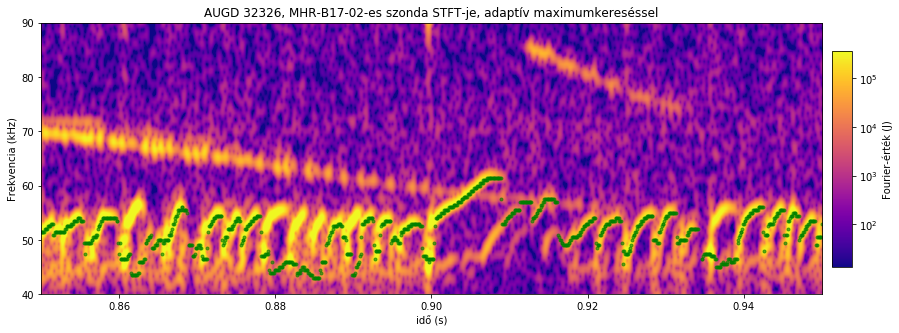

In [1005]:
logax = np.linspace(int(np.log10(z_win_fft_cutted.min())),int(np.log10(z_win_fft_cutted.max())),int(np.log10(z_win_fft_cutted.max()))-int(np.log10(z_win_fft_cutted.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(14,5))
#extent=[0,t-(2*hann_r/s_rate),0,frangemax/t],
#plt.figure(figsize=(15,10))
ax.plot(np.linspace(min(x),max(x),np.size(ridge)),ridge/1000,'.',color='g',alpha=0.6)#,linewidth=3,linestyle='dashed')#img = ax.
img = plt.imshow(z_win_fft_cutted,cmap='plasma', interpolation='gaussian', aspect='auto', extent=[min(x),max(x),frangemax/1000,0], norm=colornorm)#
#plt.title('My Short-time Fourier transform')
plt.title(shot+'-es szonda STFT-je, adaptív maximumkereséssel')
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')#('time (s)')
#plt.xlim(0.652,0.66)
plt.ylim(90,40)
plt.subplots_adjust(right=0.90)
plt.gca().invert_yaxis()
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier-érték (J)')
#plt.axis([2.13,2.15,min(s),20000])
cbar.set_ticks(logax)
plt.savefig(shot+' stft_max.pdf')
plt.show()

5.162487458321679


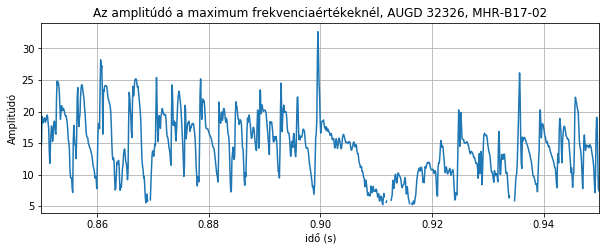

(1001, 2001)
(1000,)


In [968]:
ridge_h[ ridge_h==0 ] = np.nan
print(maxi**(1/2))
plt.figure(figsize=(10,3.5))
plt.title('Az amplitúdó a maximum frekvenciaértékeknél, '+shot)#, AUGD 34924 J051-es szonda
plt.plot(np.linspace(min(x),max(x),np.size(ridge_h)),ridge_h,'-',markersize=1)#,x,3*abs(np.sin(2*np.pi*x))+2,
plt.grid(True)
plt.xlim(min(x),max(x))
#plt.xlim(0.89,0.91)
#plt.ylim(maxi**(1/2)/2,max(ridge_h)*1.05)
plt.ylabel('Amplitúdó')
plt.xlabel('idő (s)')
#plt.yscale("log")
plt.savefig(shot+'_amp.pdf')
plt.show()
print(z_spy_stft.shape)
print(ridge.shape)

amp_diff=np.zeros(int(samples/d_win+0.9))#
for i in range(int(samples/d_win+0.9)):
    amp_diff[i]=np.sqrt(ridge_h[i])-3*abs(np.sin(2*np.pi*x[20*i]))